In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px #interactive visualizations
import seaborn as sns

import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Import tf and keras - as embedded in tensorflow!
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chaiy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaiy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chaiy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
data = pd.read_csv('data.csv')
data.columns = ["text","class"]
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaiy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chaiy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# Collect total vocabulary
lst_words = []
for i in data['text']:
    for j in i:
        lst_words.append(j)
        
# From first row to the last row, all words are stored into lst_words  
len(lst_words)

82965750

In [13]:
# Derive the number of "UNIQUE" words using set()
uni_words = len(list(set(lst_words)))
print(f"The maximum number of words in a dictionary is: {uni_words}")

The maximum number of words in a dictionary is: 121


In [14]:
# This function will print the metrcis for diffeent model
def print_model_report(y_test, prediction, ML_modelName):
    print("Model report for: "+ ML_modelName + "\n")
    
    print(classification_report(y_test, prediction, digits=4))

# Show confusion matrix plot
def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):
    cm = confusion_matrix(y_test, prediction)
    
    ax = sns.heatmap(cm, 
                     annot=True, 
                     annot_kws={'size':18,'weight':'normal'},
                     fmt='.20g', 
                     cmap=cmap, 
                     cbar_kws={'shrink':1},
                     linewidths=2)
    
    plt.title("Confusion Matrix for: " + ML_modelName)
    plt.ylabel("Actual Label")
    plt.xlabel("Predict Label")
    cbar = ax.collections[0].colorbar
    plt.show()

# Show ROC curve plot
def plot_ROC(pred_models):    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    for i in pred_models.index:
        plt.plot(pred_models.loc[i]['fpr'], 
                 pred_models.loc[i]['tpr'], 
                 label=pred_models.loc[i]['classifiers'] +", AUC={:.3f}".format(pred_models.loc[i]['auc']))


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
# Show ROC curve plot
def plot_ROC_zoom(pred_models):
    # Zoom in view of the upper left corner.
    plt.figure(1)
    plt.xlim(0, 0.2)
    plt.ylim(0.8, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    for i in pred_models.index:
        plt.plot(pred_models.loc[i]['fpr'], 
                 pred_models.loc[i]['tpr'], 
                 label=pred_models.loc[i]['classifiers'] +", AUC={:.3f}".format(pred_models.loc[i]['auc']))
                 
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

In [15]:
# Derive maxium length of token, then it will be used in word embeddings. 
max_len = -1
for idx in data['text']:
    if (len(idx)>max_len):
        max_len = len(idx) 
print(f"The maximum number of words in text is = {max_len}")

The maximum number of words in text is = 38090


In [16]:
fig = px.histogram(x = [len(i) for i in data['text']], nbins = 150)
fig.show()

In [17]:
# Identify the independent and dependent variables!
X = data['text']
y = data['class']
# Train and Test data splits!
# With pipelineLR approach!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
#Create sequences of tokenized words
MAX_NUM_WORDS = uni_words #4701
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)

tokenizer.fit_on_texts(X_train)

# Transform each token in texts to a sequence of integers!
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [19]:
print(f"Sequence training dataset length: {len(train_sequences)}")
print(f"Sequence testing dataset length: {len(test_sequences)}")

Sequence training dataset length: 35918
Sequence testing dataset length: 8980


In [20]:
#The index number corresponds to the original words in dictionary
for seq in train_sequences[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['national', 'say', 'national', 'reuters', 'right', 'national', 'party', 'group', 'political', 'said', 'statement', 'national', 'right', 'right', 'part']


In [21]:
# Understand sequence lengths in each text are not same 
for seq in train_sequences[:10]:
    print(len(seq), seq[:5], ' ...')

15 [60, 19, 60, 21, 26]  ...
77 [82, 22, 51, 86, 82]  ...
67 [1, 45, 22, 44, 1]  ...
100 [12, 51, 1, 12, 1]  ...
133 [72, 72, 40, 21, 103]  ...
50 [51, 21, 87, 15, 73]  ...
103 [1, 1, 41, 21, 8]  ...
126 [3, 52, 88, 11, 3]  ...
90 [12, 31, 51, 51, 14]  ...
6 [35, 15, 11, 88, 95]  ...


In [22]:
# Zero padding for different sequence have the same length (fillted 0 for missing)
MAX_SEQUENCE_LENGTH = 60

# pad_sequences is used to ensure that all sequences in a list have the same length!
padded_train = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH)
padded_test = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH)

In [23]:
for i,doc in enumerate(padded_train[5:10]):
     print(f"The padded encoding for document {5+1} is : {doc}")

The padded encoding for document 6 is : [  0   0   0   0   0   0   0   0   0   0  51  21  87  15  73  25 105   2
 119 113  72   5  15  32  41  15 105  15   2  89  15  23  25   2 105  19
   6  72  86  92  65 105 119  17  26  65  62  25 105 119  62   2   6  48
  39  25   2  74   3  47]
The padded encoding for document 6 is : [ 28  69   2  13  75   1  91  31   6  24  16  17   3   1 105  91  80  22
  82   1   1 106  36  81   1   1  65  91   2  25   2  36 117 101 105   3
   2  10  25   1  74  38  91  87   3   2  91  37  14  86  80  22   9  78
  14  25  83   2  75   6]
The padded encoding for document 6 is : [ 50  56 110  15  81  46  71  56  23 111 115 110  15 105 114 110  15  12
  32   4  73 103   4 100   3  47 101 106  83  41   3  15 110  97   4  72
 115 114  90 103 100  50  25  30 111  32   4   9  83 114   5  13  55  32
   4  23 107  60  50   5]
The padded encoding for document 6 is : [ 95  14  14 106  14  14   4 100 113  14   4 100  89  14  15   4 100  48
  57   4 100   3 100   4  34   4

 Accuracy of Random Forest  : 99.66000000000001 %
Model report for: Random Forest

              precision    recall  f1-score   support

           0     0.9972    0.9981    0.9977      4696
           1     0.9979    0.9970    0.9974      4284

    accuracy                         0.9976      8980
   macro avg     0.9976    0.9975    0.9975      8980
weighted avg     0.9976    0.9976    0.9976      8980



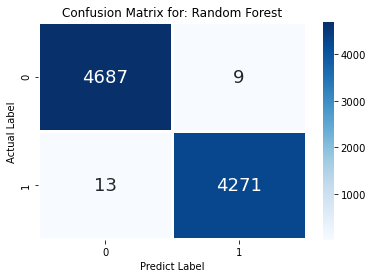

In [24]:
#StratifiedKFold is a variation of KFold!
SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
# Fitting the Logistic Regression to the Training set!
pipeline_RF = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer(norm='l2')),
                        ('model', RandomForestClassifier(n_jobs = -1, random_state = 42))])
model_RF = pipeline_RF.fit(X_train, y_train)
scores = cross_val_score(model_RF, X_train, y_train, scoring='accuracy', cv=SKF, n_jobs=-1)
print(f" Accuracy of Random Forest  : {round (np.mean(scores), 4)*100} %")
# y_pred With Pipeline
pred_RF = model_RF.predict(X_test)
# Print model report for LogisticRegression
print_model_report(y_test, pred_RF, "Random Forest")
# Visualize the Confusion Matrix for LogisticRegression!
plot_confusion_matrix(y_test, pred_RF, "Random Forest", plt.cm.Blues)

 Accuracy of Logistic Regression : 99.18 %
Model report for: Logistic Regression

              precision    recall  f1-score   support

           0     0.9923    0.9898    0.9910      4696
           1     0.9888    0.9916    0.9902      4284

    accuracy                         0.9906      8980
   macro avg     0.9906    0.9907    0.9906      8980
weighted avg     0.9907    0.9906    0.9906      8980



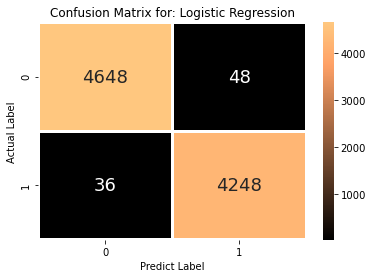

In [25]:
SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
pipeline_LR = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer(norm='l2')),
                    ('model', LogisticRegression())])
# Fitting the Logistic Regression to the Training set!
# With Pipeline option!
model_LR = pipeline_LR.fit(X_train, y_train)
# Perform the training using KFolds cross validation method!
scores = cross_val_score(model_LR, X_train, y_train, scoring='accuracy', cv=SKF, n_jobs=-1)
print(f" Accuracy of Logistic Regression : {round(np.mean(scores) ,4) * 100} %")
# y_pred With Pipeline
pred_LR = model_LR.predict(X_test) 
# Print model report for LogisticRegression
print_model_report(y_test, pred_LR, "Logistic Regression")
# Visualize the Confusion Matrix for LogisticRegression!
plot_confusion_matrix(y_test, pred_LR, "Logistic Regression", 'copper')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 256)           30976     
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 556,545
Trainable params: 556,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
141/141 [==============================] - 7s 32ms/step - loss: 0.2032 - accuracy: 0.9306 - val_loss: 0.1345 - val_accuracy: 0.9592
Epoch 2/10
141/141 [========================

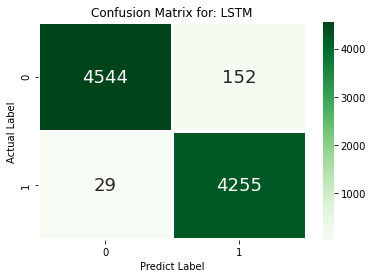

In [26]:
# The number of word in sequence
#MAX_NUM_WORDS = uni_words
# Maximum limit of length with token each sequence 
#MAX_SEQUENCE_LENGTH = 60
# Embedding word dimension 
NUM_EMBEDDING_DIM = 256
# LSTM output vector dimension 
NUM_LSTM_UNITS = 256
first_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
first_embedded = embedding_layer(first_input)
shared_lstm = LSTM(NUM_LSTM_UNITS)
first_output = shared_lstm(first_embedded)
# Dense layer for activation with sigmoid because it is a binary classification
dense =  Dense(units=1, activation='sigmoid')
predictions = dense(first_output)
model_LSTM = Model(inputs=first_input, outputs=predictions)
model_LSTM.summary()
# model_LSTM.compile: it defines the loss function, the optimizer and the metrics
model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# Convert y_train input to an array!
y_train_arr = np.asarray(y_train)
y_test_arr = np.asarray(y_test)
BATCH_SIZE = 256
# The number of execution for total training set
NUM_EPOCHS = 10
# Model training implementation
history = model_LSTM.fit(x=padded_train, 
                         y=y_train_arr,
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,
                         validation_data=(padded_test, y_test_arr), # derive loss and accuracy with validation data after each epoch
                         shuffle=True)
pred_LSTM = model_LSTM.predict(padded_test)
# if the predicted value is > 0.5, then it is real news else it is fake news!
predictions = []
for i in range(len(pred_LSTM)):
    if pred_LSTM[i].item() > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)
# Print model report for LSTM
print_model_report(y_test, predictions, "LSTM")
# Visualize the Confusion Matrix for LSTM!
plot_confusion_matrix(y_test, predictions, "LSTM", plt.cm.Greens)

In [27]:
df_auc = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pred_RF)
auc_rf = auc(fpr_rf, tpr_rf)
df_auc = df_auc.append({'classifiers':"Random Forest",
               'fpr':fpr_rf, 
               'tpr':tpr_rf, 
               'auc':auc_rf}, ignore_index=True) 


fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pred_LR)
auc_lr = auc(fpr_lr, tpr_lr)
df_auc = df_auc.append({'classifiers': "Logistic Regression(baseline)",
               'fpr':fpr_lr, 
               'tpr':tpr_lr, 
               'auc':auc_lr}, ignore_index=True) 


fpr_LSTM, tpr_LSTM, thresholds_LSTM = roc_curve(y_test_arr, pred_LSTM)
auc_LSTM = auc(fpr_LSTM, tpr_LSTM)
df_auc= df_auc.append({'classifiers': "LSTM",
               'fpr':fpr_LSTM, 
               'tpr':tpr_LSTM, 
               'auc':auc_LSTM}, ignore_index=True)

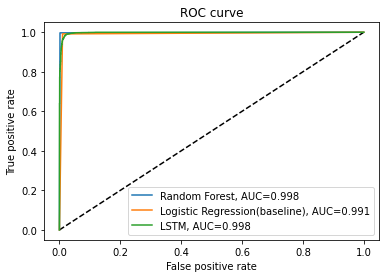

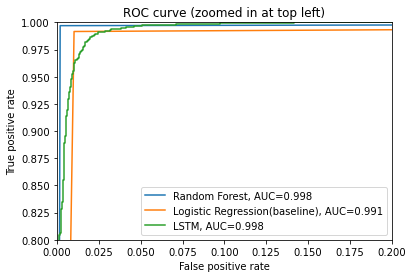

In [28]:
# The first plot is a original view of the graph
plot_ROC(df_auc)
# The second plot is a zoom-in view of the upper left corner of the graph.
plot_ROC_zoom(df_auc)